In [1294]:
import importlib
import requests
import pandas as pd
import time
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from networkx.algorithms.community import k_clique_communities
from collections import defaultdict, Counter
from itertools import combinations
import utils
importlib.reload(utils)
from utils import *

%matplotlib inline

## Data extraction and preprocessing

Выкачаем данные о фильмах ТОП-250 Кинопоиска:

In [707]:
films_data = []

params = {'Content-Type': 'application/json',
          'X-API-KEY': 'f3984952-d49c-4bd3-8d22-7ea1a7bb666a'}

for n_page in range(1, 14):
    url = f'https://kinopoiskapiunofficial.tech/api/v2.2/films/top?type=TOP_250_BEST_FILMS&page={n_page}'
    r = requests.get(url, headers=params).text
    page_films_data = json.loads(r)
    page_films_data = page_films_data['films']
    films_data.extend(page_films_data)

Выкачаем для каждого фильма из ТОП-250 похожие фильмы:

In [712]:
api_keys = ['f3984952-d49c-4bd3-8d22-7ea1a7bb666a',
            'bc26920e-3473-41ce-b1bc-04bf04a55493']

params = {'Content-Type': 'application/json',
          'X-API-KEY': 'c56f26be-faf8-4179-a24c-fd957ad0a93c'}

for i, film_info in tqdm(enumerate(films_data)):
    film_id = film_info['filmId']
    url = f'https://kinopoiskapiunofficial.tech/api/v2.2/films/{film_id}/similars'
    r = requests.get(url, headers=params)
    if r.ok:
        related_films = json.loads(r.text)
        film_info['related'] = related_films
    else:
        params['X-API-KEY'] = api_keys.pop(0)

250it [00:14, 17.13it/s]


Добавим в вершины и ребра нашего графы: вершины - фильмы, и ребра - наличие одного фильма у другого в похожих.

In [737]:
edges = []
nodes = set()
labels_info = []

for j, film_info in enumerate(films_data):
    current_film_id = film_info['filmId']
    current_film_name = film_info['nameRu']
    nodes.add(current_film_name)
    labels_info.append(current_film_genre)
    for i, related_film in enumerate(film_info['related']['items']):
        related_film_name = related_film['nameRu']
        labels_info.append(related_film_genre)
        nodes.add(related_film_name)
        edges.append((current_film_name, related_film_name))

In [732]:
G = nx.Graph()
G.add_edges_from(edges)

Найдем максимально соединенную компоненту:

In [733]:
cuttedG = G.copy()
max_connected_nodes = list(nx.connected_components(G))[0]

In [734]:
for node in G.nodes:
    if node not in max_connected_nodes:
        cuttedG.remove_node(node)

In [736]:
len(cuttedG.nodes)

257

In [1109]:
cutted_films_data = [
    film_info for film_info in films_data if film_info['nameRu'] in cuttedG.nodes]

In [1110]:
len(cutted_films_data)

127

После чего в нашем json-е перепишем информацию о похожих фильмах, т.к. она дается неполно, приходится таким образом экономить лимиты данные в API, и перезаписываем информацию первоначально записанных похожие фильмов на более полную информацию о них.

In [742]:
api_keys = ['f3984952-d49c-4bd3-8d22-7ea1a7bb666a',
            'bc26920e-3473-41ce-b1bc-04bf04a55493']

params = {'Content-Type': 'application/json',
          'X-API-KEY': 'c56f26be-faf8-4179-a24c-fd957ad0a93c'}

for i, film_info in tqdm(enumerate(cutted_films_data)):
    related_films_ids = [item['filmId'] for item in film_info['related']
                         ['items'] if item['nameRu'] in cuttedG.nodes]
    related_film_info_list = []
    for related_film_id in related_films_ids:
        url = f'https://kinopoiskapiunofficial.tech/api/v2.2/films/{related_film_id}'
        r = requests.get(url, headers=params)
        if r.ok:
            related_film_info = json.loads(r.text)
        else:
            params['X-API-KEY'] = api_keys.pop(0)
            r = requests.get(url, headers=params)
            if r.ok:
                related_film_info = json.loads(r.text)
        related_film_info_list.append(related_film_info)
    film_info['related'] = related_film_info_list

127it [00:45,  2.81it/s]


Вынимаем информацию о вершинах и ребрах, а также информацию о жанрах, попробуем это позже визулизировать.

In [821]:
edges = []
nodes = set()
name_to_genre = dict()

for film_info in cutted_films_data:
    current_film_id = film_info['filmId']
    current_film_name = film_info['nameRu']
    if len(film_info['genres']) >= 2:
        current_film_genre = [film_info['genres'][0]
                              ['genre'], film_info['genres'][1]['genre']]
        current_film_genre = ' '.join(sorted(current_film_genre))
    else:
        current_film_genre = film_info['genres'][0]['genre']
    nodes.add(current_film_name)
    name_to_genre[current_film_name] = current_film_genre

    for related_film in film_info['related']:
        related_film_name = related_film['nameRu']
        if related_film_name in cuttedG.nodes:
            if len(related_film['genres']) >= 2:
                related_film_genre = [related_film['genres'][0]
                                      ['genre'], related_film['genres'][1]['genre']]
                related_film_genre = ' '.join(sorted(related_film_genre))
            else:
                related_film_genre = related_film['genres'][0]['genre']
            name_to_genre[related_film_name] = related_film_genre
            nodes.add(related_film_name)
            edges.append((current_film_name, related_film_name))

In [822]:
assert len(nodes) == len(name_to_genre)

Формируем граф:

In [1042]:
cuttedG = nx.Graph()
cuttedG.add_edges_from(edges)
cuttedG.add_nodes_from(nodes)
cuttedG.remove_edges_from(list(nx.selfloop_edges(cuttedG)))

## Network summary

### Тип графа:
<br>
<li> Ненаправленный</li>
<li>Невзвешенный</li>
    

In [1295]:
print('Число вершин:', len(cuttedG.nodes))
print('Число ребер:', len(cuttedG.edges))

diameter = nx.diameter(cuttedG)
radius = nx.radius(cuttedG)

print(f'Диаметр графа: {diameter}')
print(f'Радиус графа: {radius}')

Число вершин: 257
Число ребер: 556
Диаметр графа: 15
Радиус графа: 8


Посмотрим на распределение степеней вершин:

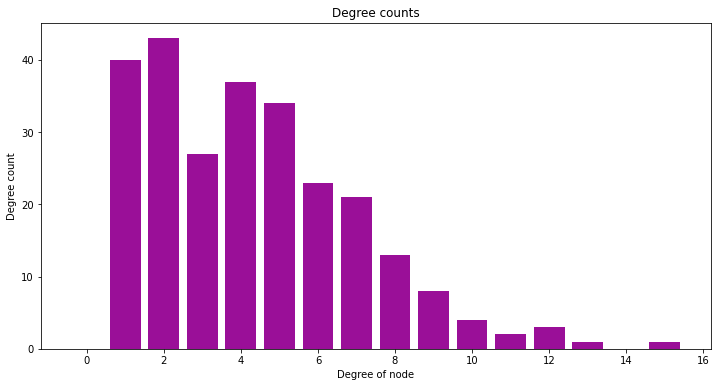

In [1296]:
plt.figure(figsize=(12, 6))
degrees = nx.degree_histogram(cuttedG)
plt.bar(list(range(len(degrees))), degrees, color='#9A0F98')
plt.xlabel('Degree of node')
plt.ylabel('Degree count')
plt.title('Degree counts')
plt.show()

Максимальное количество вершин со степенью 2. Т.к. граф мы урезали до максимально соединенной компоненты, вершины со степенью 0 отсутствуют. Распределение напоминает распределение Пуассона.

Теперь визуализируем эмпирическую функцию распределения и посмотрим как она сочетается с теоретическим законом распределения.

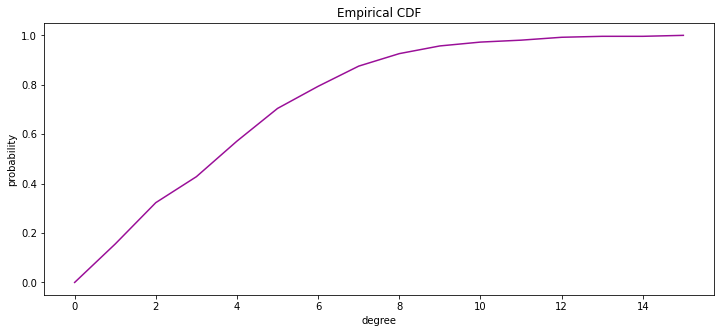

In [1297]:
ecdf = empirical_cdf(cuttedG)

plt.figure(figsize=(12,5))
plt.plot(ecdf, color='#9A0F98')
plt.xlabel('degree')
plt.ylabel('probability')
plt.title('Empirical CDF')
plt.show()

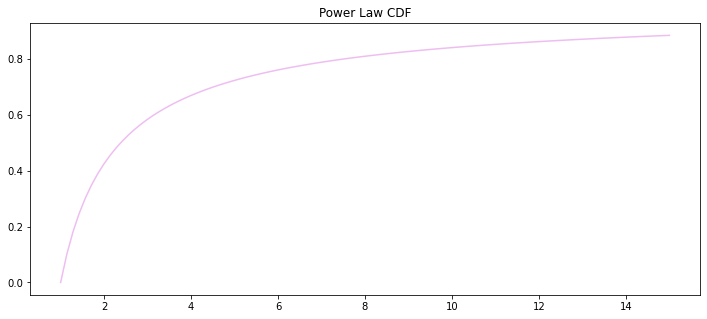

In [1298]:
plt.figure(figsize=(12,5))
x_space = np.linspace(1, 15, 100)
plt.plot(x_space, power_law_cdf(x_space, alpha=1.8), color='#eebef1')
plt.title('Power Law CDF');

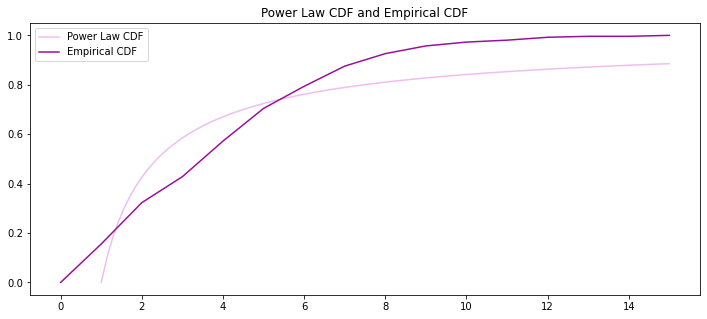

In [1299]:
plt.figure(figsize=(12,5))
x_space = np.linspace(1, 15, 100)
plt.plot(x_space, power_law_cdf(x_space, alpha=1.8), color='#eebef1', label='Power Law CDF')
plt.plot(ecdf, color='#9A0F98',  label='Empirical CDF')
plt.legend()
plt.title('Power Law CDF and Empirical CDF');

Эмпирическое распределение и теоретическое распределения имеют различия по той причине, что полученный граф, вероятнее всего является чуть более связанным, нежели чем, это должно быть в теории, то есть вершины в данном графе априори связаны сильнее, чем это должно было быть, поэтому можно увидеть что после 5 вершин эмпирический CDF расходится с теоретическим и идет вверх быстрее, чем в теории. Вероятность выбрать вершину с большим числом входящих ребер выше, чем в теории.

Далее посмотрим на коэффициенты кластеризации:

In [1300]:
avg_clustering_coef_cuttedG = nx.average_clustering(cuttedG)

clustering_coef = nx.clustering(cuttedG)

print(
    f'Global clustering coefficient of cuttedG: {avg_clustering_coef_cuttedG:.2f}', )

Global clustering coefficient of cuttedG: 0.25


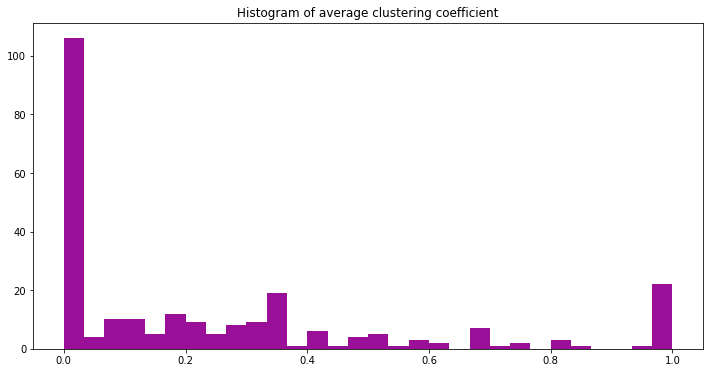

In [1459]:
plt.figure(figsize=(12,6))
plt.hist(clustering_coef.values(), color='#9A0F98',bins=30)
plt.title('Histogram of average clustering coefficient')
plt.show()

Как видно из графика выше у нас существует достаточно большое количество вершин с коэффициентом кластеризации равному 1, это вероятнее всего подтверждает тот вывод, который был сделан для CDF, и что вершин связных между собой, больше, чем это должно было быть в теории.

Далее посмотрим на распределение средней длины кратчайших путей:

In [1302]:
path_lengths = []

for u, v in list(combinations(cuttedG.nodes, 2)):
    shortest_path_length = nx.shortest_path_length(cuttedG, u, v)
    path_lengths.append(shortest_path_length)

In [1303]:
counter_path_lengths = Counter(path_lengths)

In [1304]:
avg_path_length = nx.average_shortest_path_length(cuttedG)

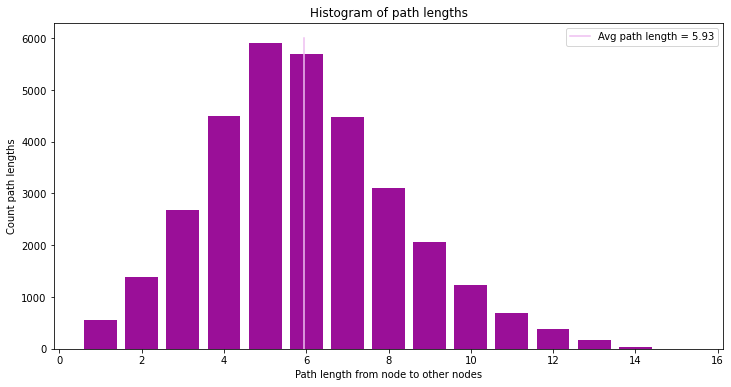

In [1305]:
plt.figure(figsize=(12, 6))
plt.bar(list(counter_path_lengths.keys()), list(
    counter_path_lengths.values()), color='#9A0F98')
plt.plot([avg_path_length] * 2, [0, 6000], color='#eebef1',
         label=f'Avg path length = {avg_path_length:.2f}')
plt.title('Histogram of path lengths')
plt.xlabel('Path length from node to other nodes')
plt.ylabel('Count path lengths')

plt.legend()
plt.show()

## Structural Analysis

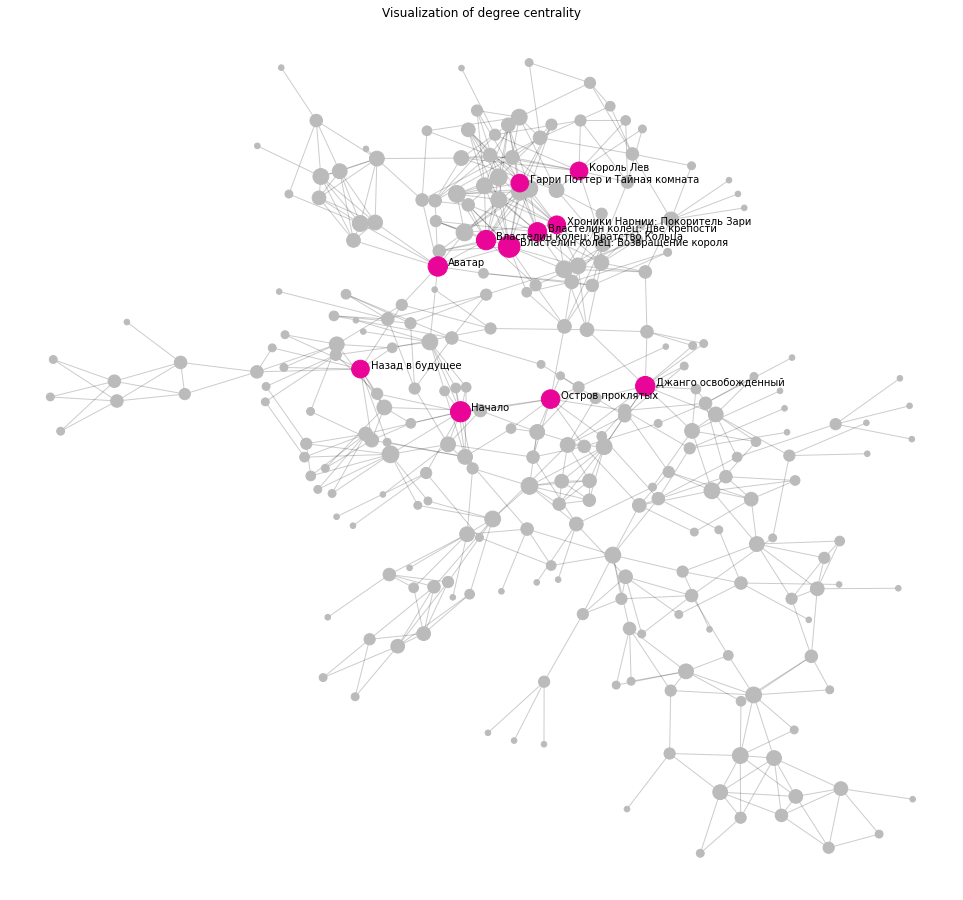

Наименование фильма: Властелин колец: Возвращение короля 
Degree centrality: 0.059

Наименование фильма: Начало 
Degree centrality: 0.051

Наименование фильма: Аватар 
Degree centrality: 0.047

Наименование фильма: Властелин колец: Братство Кольца 
Degree centrality: 0.047

Наименование фильма: Джанго освобожденный 
Degree centrality: 0.047

Стандартное отклонение: 0.01


In [1509]:
layout = nx.kamada_kawai_layout(cuttedG)
plot_graph_by_centrality_measure(cuttedG, layout, 'degree', False)

for name, value in sorted(nx.degree_centrality(cuttedG).items(), key=lambda x: x[1], reverse=True)[:5]:
    print('Наименование фильма:', name, '\nDegree centrality:', round(value, 3))
    print()

print('Стандартное отклонение:', np.array(
    list(nx.degree_centrality(cuttedG).values())).std().round(2))

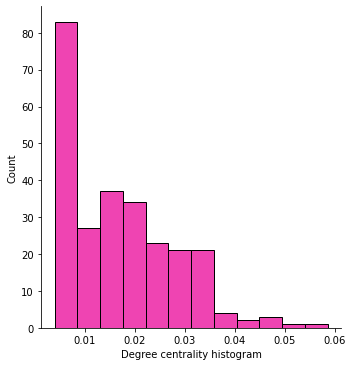

In [1454]:
sns.displot(list(nx.degree_centrality(cuttedG).values()), color='#EA0599')
plt.xlabel('Degree centrality histogram')
plt.show()

Вывод: фильмы указанные выше обладают наибольшим значением degree centrality, потому что имеют наибольшее число схожих с ними фильмов, тот же Властелин колец имеет множество сиквелов, поэтому в данные фильмы входят множество других таких же фильмов - сиквелов, Начало - фильм, который задал новый жанр и произвел множество последователей, поэтому у него также множество схожих фильмов - а это как следствие увеличивает degree centrality данных картин.

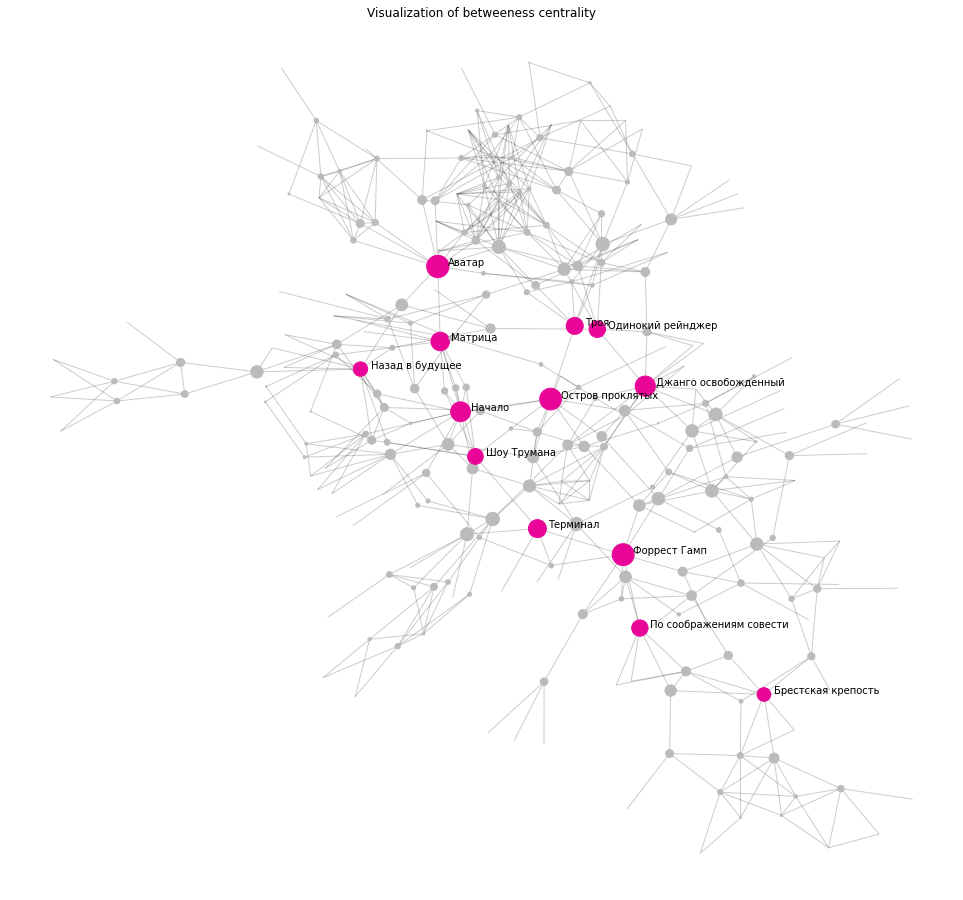

Наименование фильма: Аватар 
Betweenness centrality: 0.198

Наименование фильма: Форрест Гамп 
Betweenness centrality: 0.192

Наименование фильма: Остров проклятых 
Betweenness centrality: 0.189

Наименование фильма: Джанго освобожденный 
Betweenness centrality: 0.162

Наименование фильма: Начало 
Betweenness centrality: 0.156

Стандартное отклонение: 0.03


In [1508]:
layout = nx.kamada_kawai_layout(cuttedG)
plot_graph_by_centrality_measure(cuttedG, layout, 'betweeness')

for name, value in sorted(nx.betweenness_centrality(cuttedG).items(), key=lambda x: x[1], reverse=True)[:5]:
    print('Наименование фильма:', name,
          '\nBetweenness centrality:', round(value, 3))
    print()

print('Стандартное отклонение:', np.array(
    list(nx.betweenness_centrality(cuttedG).values())).std().round(2))

Вывод: в отличие от предыдущей метрики, betweeness centrality нам указывает на те фильмы, которые соединяют части графов между собой (т.е. разные жанры или характеристики похожести), как следствие данные фильмы являются средним между характеристиками фильмов лежащих в различных частях графа. В топе находится "Аватар" - он является одновременно и драмой, и фантастикой, и экшеном - и это как раз говорит о том, что данная картина находится в середине соединений всего графа.

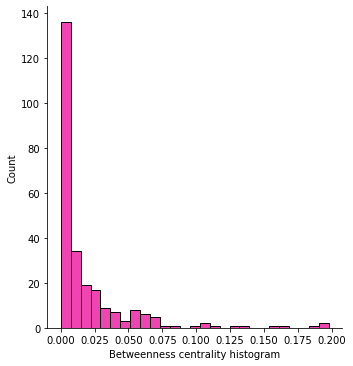

In [1455]:
sns.displot(list(nx.betweenness_centrality(cuttedG).values()), color='#EA0599')
plt.xlabel('Betweenness centrality histogram')
plt.show()

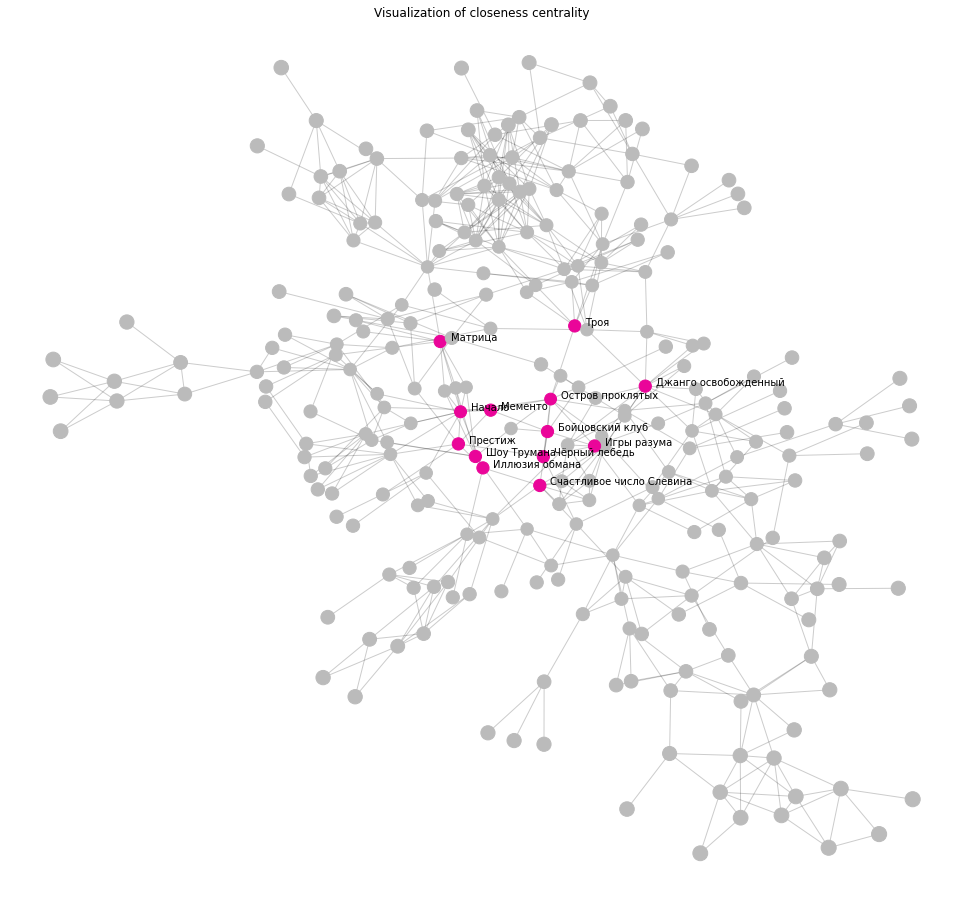

Наименование фильма: Остров проклятых 
Closeness centrality: 0.246

Наименование фильма: Начало 
Closeness centrality: 0.239

Наименование фильма: Бойцовский клуб 
Closeness centrality: 0.226

Наименование фильма: Чёрный лебедь 
Closeness centrality: 0.226

Наименование фильма: Игры разума 
Closeness centrality: 0.225

Стандартное отклонение: 0.03


In [1507]:
layout = nx.kamada_kawai_layout(cuttedG)
plot_graph_by_centrality_measure(cuttedG, layout, 'closeness')

for name, value in sorted(nx.closeness_centrality(cuttedG).items(), key=lambda x: x[1], reverse=True)[:5]:
    print('Наименование фильма:', name,
          '\nCloseness centrality:', round(value, 3))
    print()

print('Стандартное отклонение:', np.array(
    list(nx.closeness_centrality(cuttedG).values())).std().round(2))

Вывод: значения closeness centrality показывает точную середину графа, то есть от данных фильмов до любых других фильмов путь в среднем минимален.

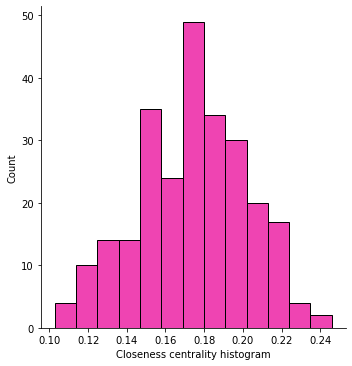

In [1456]:
sns.displot(list(nx.closeness_centrality(cuttedG).values()), color='#EA0599')
plt.xlabel('Closeness centrality histogram')
plt.show()

Из-за того, что нет нулевых значений, визуализация размер вершин с centrality значением практически равны.

In [1503]:
import utils
importlib.reload(utils)
from utils import *

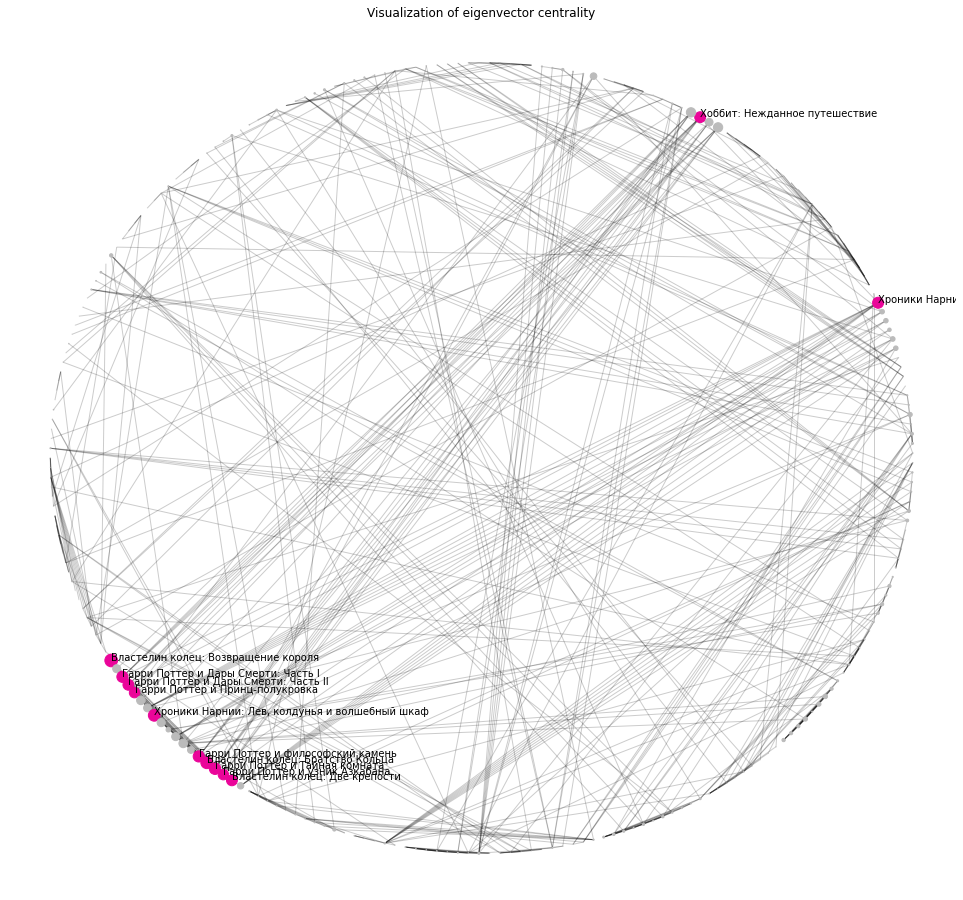

Наименование фильма: Властелин колец: Возвращение короля 
Eigenvector centrality: 0.321

Наименование фильма: Властелин колец: Братство Кольца 
Eigenvector centrality: 0.285

Наименование фильма: Хроники Нарнии: Лев, колдунья и волшебный шкаф 
Eigenvector centrality: 0.275

Наименование фильма: Гарри Поттер и Тайная комната 
Eigenvector centrality: 0.26

Наименование фильма: Гарри Поттер и Дары Смерти: Часть I 
Eigenvector centrality: 0.25

Стандартное отклонение: 0.06


In [1515]:
layout = nx.shell_layout(cuttedG)
plot_graph_by_centrality_measure(cuttedG, layout, 'eigenvector', False)

for name, value in sorted(nx.eigenvector_centrality(cuttedG).items(), key=lambda x: x[1], reverse=True)[:5]:
    print('Наименование фильма:', name,
          '\nEigenvector centrality:', round(value, 3))
    print()

print('Стандартное отклонение:', np.array(
    list(nx.eigenvector_centrality(cuttedG).values())).std().round(2))

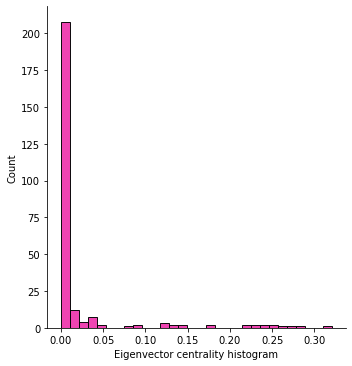

In [1505]:
sns.displot(list(nx.eigenvector_centrality(cuttedG).values()), bins=30, color='#EA0599')
plt.xlabel('Eigenvector centrality histogram')
plt.show()

Как видно здесь в топе находятся фильмы, которые имеют наибольшее число сиквелов, то есть продолжений, получается, что чем больше связей между этими фильмами, тем больше значение их eigenvector centrality. Плюс жанры и тематика данных фильмов также схожа между собой, то есть значение eigenvector centrality усиливается наличием сиквелов и наличием похожих по жанру фильмов (фентези, приключения).

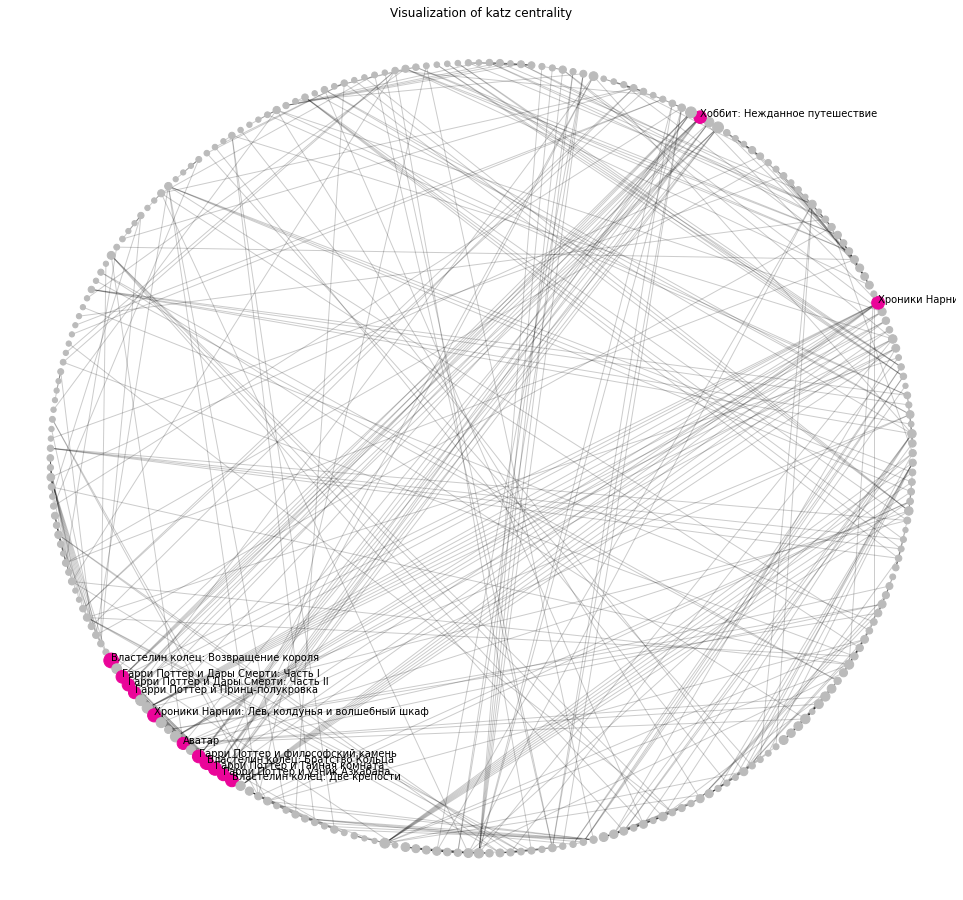

Наименование фильма: Властелин колец: Возвращение короля 
Katz centrality: 0.217

Наименование фильма: Властелин колец: Братство Кольца 
Katz centrality: 0.189

Наименование фильма: Хроники Нарнии: Лев, колдунья и волшебный шкаф 
Katz centrality: 0.174

Наименование фильма: Гарри Поттер и Тайная комната 
Katz centrality: 0.17

Наименование фильма: Властелин колец: Две крепости 
Katz centrality: 0.165

Стандартное отклонение: 0.03


In [1513]:
layout = nx.shell_layout(cuttedG)
# layout = nx.spring_layout(cuttedG)

# layout = nx.kamada_kawai_layout(cuttedG)
plot_graph_by_centrality_measure(cuttedG, layout, 'katz', False)

for name, value in sorted(nx.katz_centrality(cuttedG).items(), key=lambda x: x[1], reverse=True)[:5]:
    print('Наименование фильма:', name, '\nKatz centrality:', round(value, 3))
    print()

print('Стандартное отклонение:', np.array(
    list(nx.katz_centrality(cuttedG).values())).std().round(2))

Ситуация схожа с предыдущей метрикой eigenvector: количество сиквелов-приквелов, схожесть по жанру. Разве, что здесь появился Аватар, из-за того, что в katz centrality учитывается значение betweenness между вершинами.

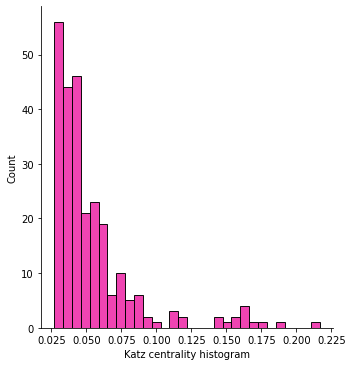

In [1502]:
sns.displot(list(nx.katz_centrality(cuttedG).values()), bins=30, color='#EA0599')
plt.xlabel('Katz centrality histogram')
plt.show()

## Community Detection

### K-cores

In [1082]:
kcores = defaultdict(list)

for name, kcore in nx.core_number(cuttedG).items():
    kcores[kcore].append(name)

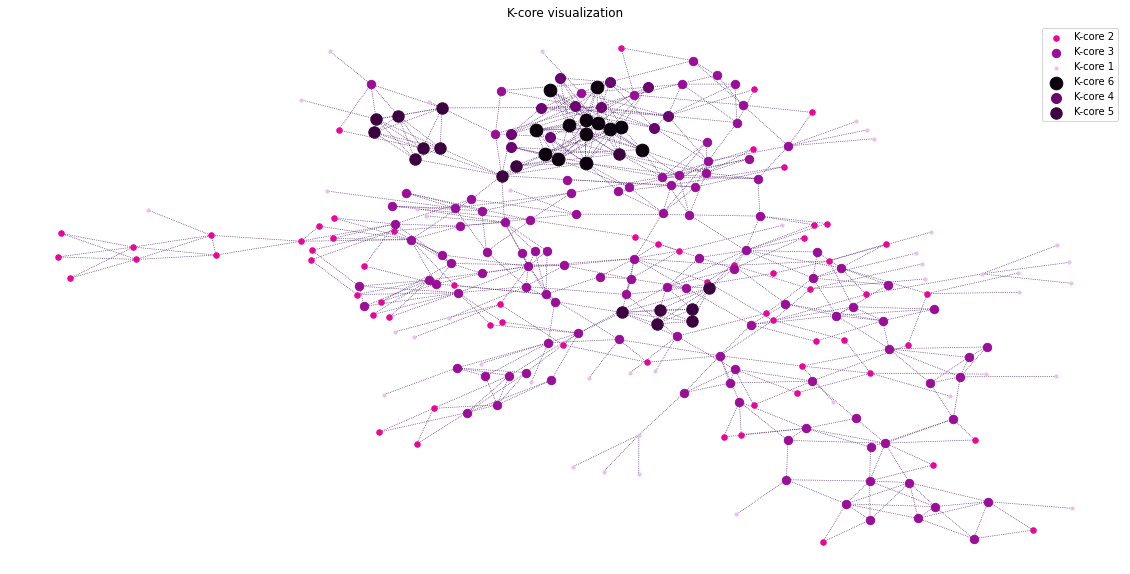

In [1242]:
plt.figure(figsize=(20, 10))

layout = nx.kamada_kawai_layout(cuttedG)

colors = {1: '#eebef1', 2: '#EA0599', 3: '#9A0F98',
          4: '#6A0572', 5: '#3c0340', 6: '#0e010f'}
sizes = {1: 10, 2: 30, 3: 70, 4: 100, 5: 130, 6: 160}

for kcore, nodes in kcores.items():
    nx.draw_networkx_nodes(cuttedG, pos=layout, nodelist=nodes,
                           node_size=sizes[kcore], node_color=colors[kcore], label=f'K-core {kcore}')

nx.draw_networkx_edges(cuttedG, pos=layout, width=0.7,
                       style='dotted', edge_color='#39065A')
plt.title('K-core visualization')
plt.legend()
plt.axis('off')

plt.show()

In [1434]:
print('Вершины с максимальным k-core значением:\n')
print('\n'.join(sorted(kcores[6])))

Вершины с максимальным k-core значением:

Властелин колец: Братство Кольца
Властелин колец: Возвращение короля
Гарри Поттер и Дары Смерти: Часть I
Гарри Поттер и Дары Смерти: Часть II
Гарри Поттер и Принц-полукровка
Гарри Поттер и Тайная комната
Гарри Поттер и узник Азкабана
Гарри Поттер и философский камень
Перси Джексон и похититель молний
Фантастические твари и где они обитают
Хоббит: Нежданное путешествие
Хроники Нарнии: Лев, колдунья и волшебный шкаф
Хроники Нарнии: Покоритель Зари


### Clique search

In [1085]:
cliques = nx.enumerate_all_cliques(cuttedG)
top_cliques = list(cliques)

In [1086]:
top_cliques = [clique for clique in top_cliques if len(clique) == 3]

In [1090]:
edge_params = drawing_edges_params(cuttedG, top_cliques)
node_params = drawing_nodes_params(cuttedG, top_cliques)

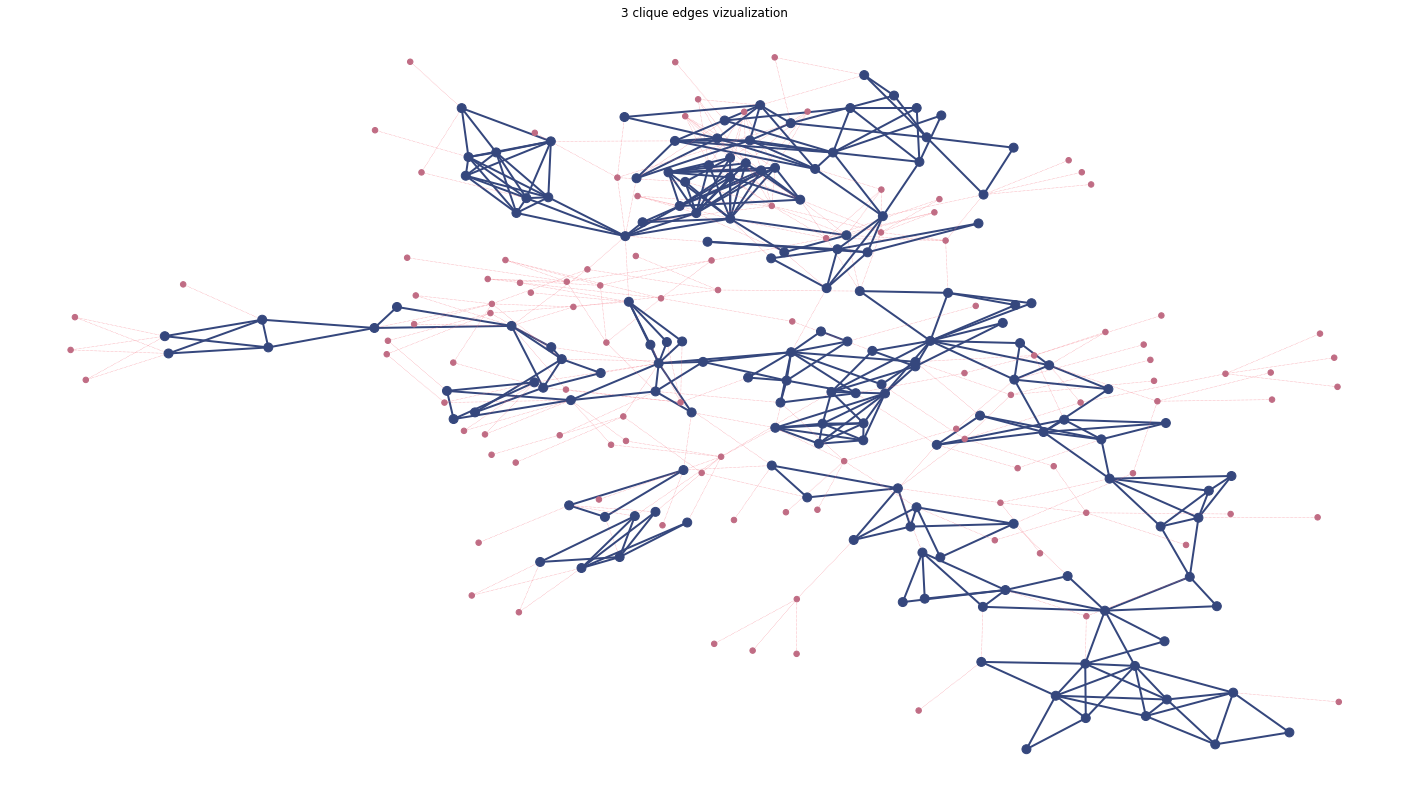

In [1283]:
plt.figure(figsize=(25, 14))
nx.draw_networkx_nodes(**node_params, )
nx.draw_networkx_edges(**edge_params)
plt.title('3 clique edges vizualization')
plt.axis('off')

plt.show()

### Clusterization by genres

Для начала получим своеобразный бейзлайн по кластеризации с помощью жанров фильмов:

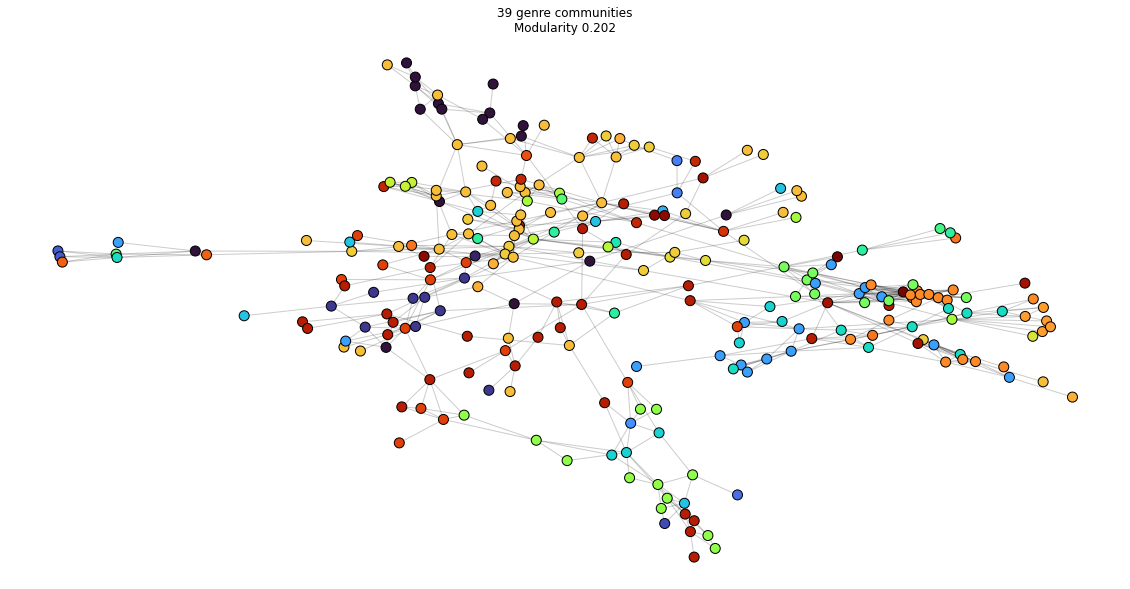

In [1452]:
genre_to_idx = {name: i for i, name in enumerate(set(name_to_genre.values()))}

idx_genres_to_film_idx = [genre_to_idx[genre] for name, genre in name_to_genre.items()]
n_genre_communities = len(set(idx_genres_to_film_idx))
genre_communities = [[] for i in range(n_genre_communities)]

for film_id, genre_id in enumerate(idx_genres_to_film_idx):
    genre_communities[genre_id].append(film_id)
    
plt.figure(figsize=(20, 10))
layout = nx.spring_layout(cuttedG)
nx.draw_networkx_nodes(cuttedG,
                       pos=layout,
                       node_size=100,
                       edgecolors='black',
                       cmap=plt.cm.turbo,
                       node_color=idx_genres_to_film_idx)
#                        node_color=['#2c75ff' if i in top_n_inds else '#bbbbbb' for i, val in enumerate(centralities)],
#                        node_size=[node_size_func(dgc) for name, dgc in centralities.items()])
nx.draw_networkx_edges(cuttedG, pos=layout, alpha=0.2)
plt.title(
    '{} genre communities\nModularity {:.3f}'.format(
        n_genre_communities,
        nx.community.modularity(int_cuttedG, genre_communities)
    )
)
plt.axis('off')

plt.show()

Значение modularity=0.2, маленькое значение, по той причине, что у фильма может быть несколько жанров, а каждый второй фильм обладает жанром "Драма".

Посмотрим на несколько методов кластеризации и их результат по метрике Modularity.

### Girvan Newman method

In [1438]:
n_clusters = 14
int_cuttedG = nx.convert_node_labels_to_integers(cuttedG)
labels = girvan_newman(int_cuttedG, n_clusters)
pos = nx.kamada_kawai_layout(int_cuttedG)

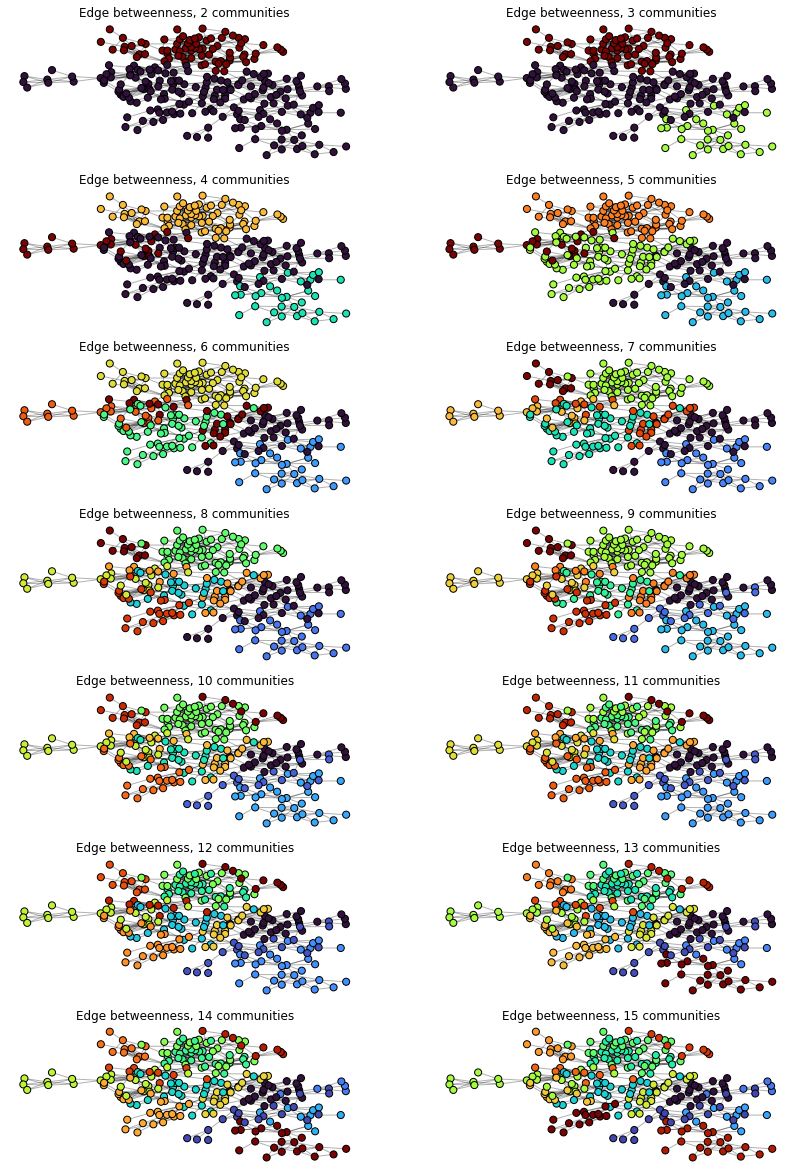

In [1439]:
plt.figure(figsize=(7*2, 7*3))

for i in range(labels.shape[0]):
    plt.subplot(n_clusters // 2, 2, i+1)
    nx.draw_networkx_nodes(
        int_cuttedG, 
        pos,
        cmap=plt.cm.turbo,
        node_color=labels[i], 
        node_size=50, 
        edgecolors='black'
    )
    nx.draw_networkx_edges(int_cuttedG, pos, alpha=0.3)
    plt.title('Edge betweenness, {} communities'.format(i+2))
    plt.axis('off')

In [1440]:
n_iterations = 20
mod_val = edge_betw_modularity(int_cuttedG, n_iterations)

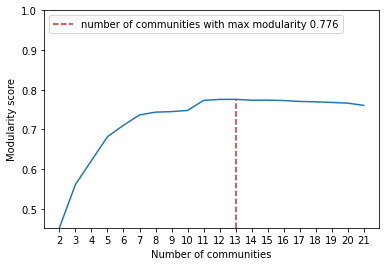

In [1441]:
plt.figure(figsize=(6, 4))
plt.plot(np.arange(n_iterations)+2, mod_val)
best_n = np.argmax(mod_val) + 2
label = 'number of communities with max modularity {:.3f}'.format(max(mod_val))
plt.plot(
    [best_n, best_n], [min(mod_val), max(mod_val)],
    linestyle='--', c='tab:red',
    label=label
)
plt.ylabel('Modularity score')
plt.xlabel('Number of communities')
plt.legend(loc='upper left')
plt.xticks(np.arange(n_iterations)+2)
plt.ylim((mod_val.min(), 1))
plt.show()

Видим, что максимальное значение modularity достигается при числе communities = 13.
Визуализируем граф для этого значения отдельно:

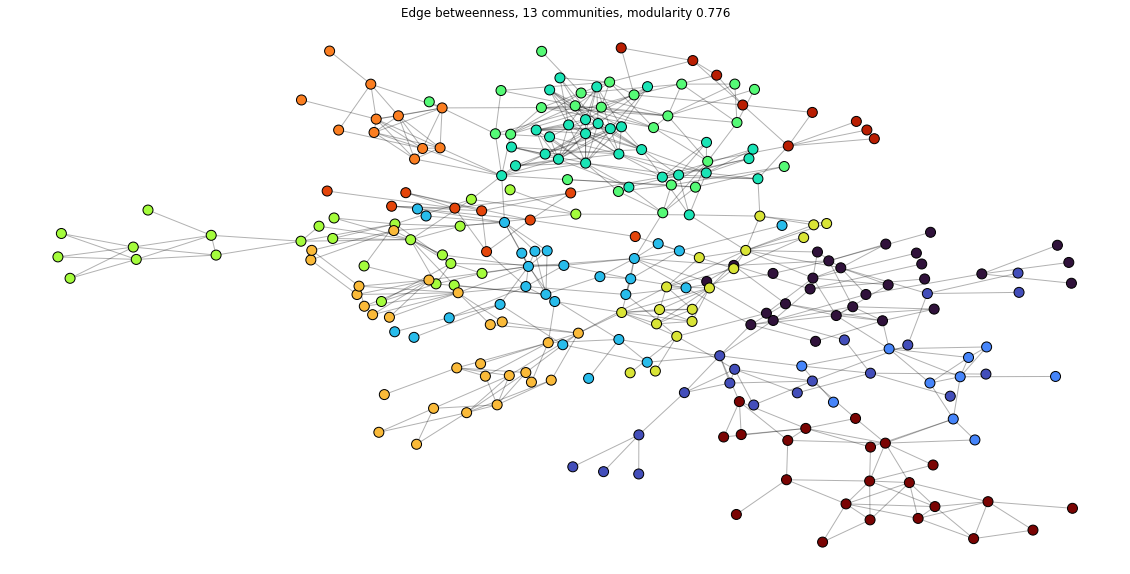

In [1444]:
plt.figure(figsize=(20, 10))
nx.draw_networkx_nodes(
    int_cuttedG,
    pos,
    cmap=plt.cm.turbo,
    node_color=labels[best_n-2],
    node_size=100,
    edgecolors='black'
)

nx.draw_networkx_edges(int_cuttedG, pos, alpha=0.3)
plt.title('Edge betweenness, {} communities, modularity {}'.format(
    len(set(labels[best_n-2])), round(max(mod_val), 3)))
plt.axis('off')
plt.show()

В принципе получилось неплохое разделение за исключением несколько выбросов в различных кластерах.<br> Modularity данного разбиения равно 0.776.

### Louvain method

In [1445]:
iterG = int_cuttedG.copy()
prev_comm, labels, iterG = louvain_method(iterG)

for i in range(2):
    next_comm, labels, iterG = louvain_method(iterG)
    communities = []
    for c in next_comm:
        temp = []
        for node in c:
            temp.extend(prev_comm[node])
        communities.append(temp)
    prev_comm = communities.copy()

labels = np.zeros(len(int_cuttedG))
for i, c in enumerate(communities):
    labels[c] = i

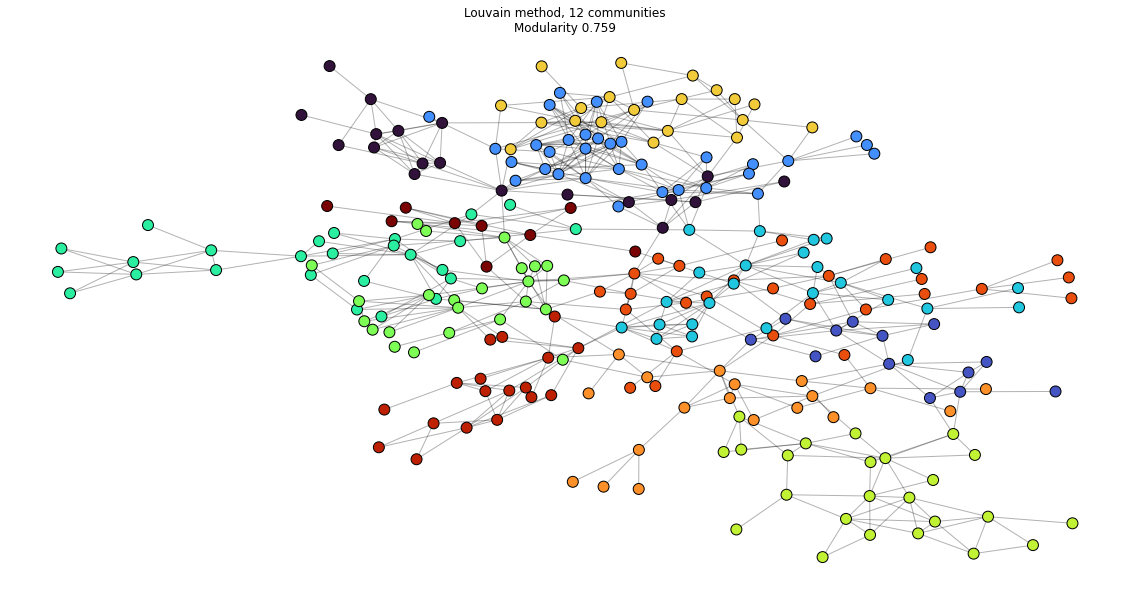

In [1446]:
plt.figure(figsize=(20, 10))
nx.draw_networkx_nodes(
    int_cuttedG,
    pos,
    cmap=plt.cm.turbo,
    node_color=labels,
    node_size=120,
    edgecolors='black'
)
nx.draw_networkx_edges(int_cuttedG, pos, alpha=0.3)
plt.title(
    'Louvain method, {} communities\nModularity {:.3f}'.format(
        len(communities),
        nx.community.modularity(int_cuttedG, communities)
    )
)
plt.axis('off')
plt.show()

Тоже неплохое разбиение, но бирюзовые, синие и красные вершины в правой части графа смешались слишком сильно, поэтому значение Modularity ниже, чем у предыдущего метода.

### Asyn Fluid communities

In [1449]:
n_iterations = 20
mod_val = asyn_fluidc_modularity(int_cuttedG, n_iterations)

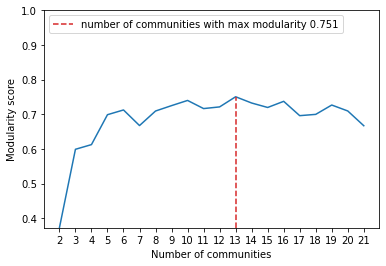

In [1450]:
plt.figure(figsize=(6, 4))
plt.plot(np.arange(n_iterations)+2, mod_val)
best_n = np.argmax(mod_val) + 2
label = 'number of communities with max modularity {:.3f}'.format(max(mod_val))
plt.plot(
    [best_n, best_n], [min(mod_val), max(mod_val)],
    linestyle='--', c='tab:red',
    label=label
)
plt.ylabel('Modularity score')
plt.xlabel('Number of communities')
plt.legend(loc='upper left')
plt.xticks(np.arange(n_iterations)+2)
plt.ylim((mod_val.min(), 1))
plt.show()

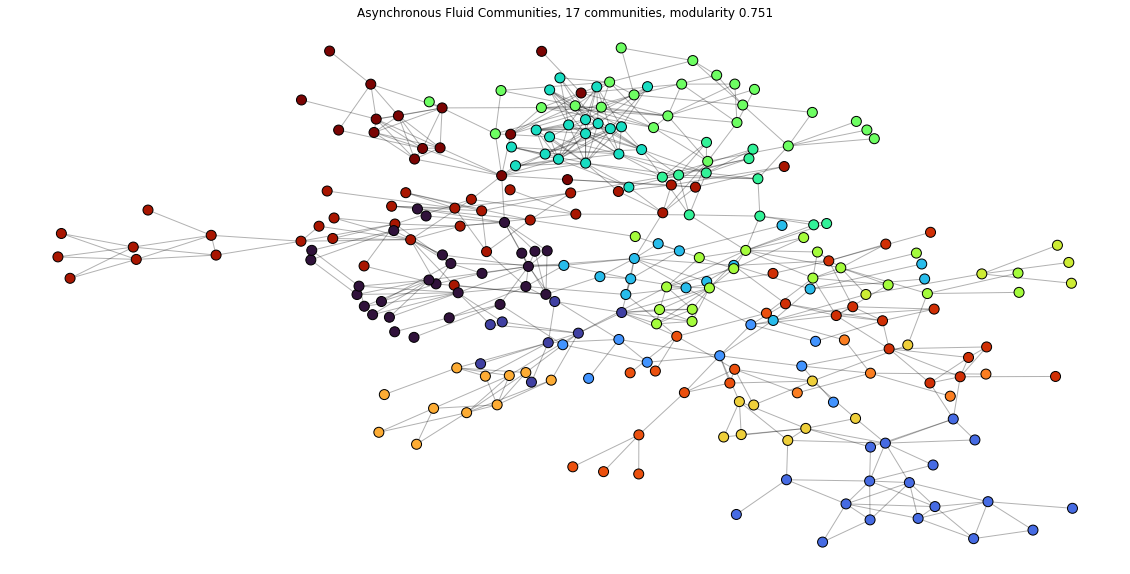

In [1451]:
asyn_fluidc_labels = list(nx.algorithms.community.asyn_fluidc(int_cuttedG, 17))
fluidc_labels = [[j for j, l in enumerate(
    asyn_fluidc_labels) if i in l][0] for i in range(len(int_cuttedG.nodes))]

plt.figure(figsize=(20, 10))
nx.draw_networkx_nodes(
    int_cuttedG,
    pos,
    cmap=plt.cm.turbo,
    node_color=fluidc_labels,
    node_size=100,
    edgecolors='black'
)

nx.draw_networkx_edges(int_cuttedG, pos, alpha=0.3)
plt.title('Asynchronous Fluid Communities, {} communities, modularity {}'.format(
    len(set(fluidc_labels)), round(max(mod_val), 3)))
plt.axis('off')
plt.show()

Наихудшая кластеризация, слишком много смешанных кластеров, а также отдельных выбросов.

### Общий вывод по кластеризации

Наиболее лучшим образом и по метрике и визуально отработал алгоритм Girvan Newman clusterization, построенный на определении ребер с наибольшим значением Beetweeness, а т.к. граф заметно разделен на кластеры и эти кластеры соединены единственным ребром, то есть явно существуют кластеры, которые отделены от других, то удаление подобных ребер дает наилучшую метрику Modularity при кластеризации.